In [1]:
import numpy as np
import torch
import awkward as ak
import fastjet
import vector
import uproot


def extract_features(dataset, min_num=0, max_num=128, num_jets=None):
    if isinstance(dataset, list):
        all_data = []
        for data in dataset:
            assert  '.root' in data, 'Input should be a path to a .root file or a tensor'
            data = read_root_file(data)
            features = ['part_ptrel', 'part_etarel', 'part_phirel', 'part_isGhost', 'part_isPhoton', 'part_isNeutralHadron', 'part_isChargedHadron', 'part_isElectron', 'part_isMuon', 'part_charge', 'mask']       
            data = torch.tensor(np.stack([ak.to_numpy(pad(data[feat], min_num=min_num, max_num=max_num, value=0)) for feat in features] , axis=1))
            data = torch.permute(data, (0,2,1))   
            continuous = data[...,0:3] 
            data[..., 3] -= 1                   # creates ghost one-hot entry from mask 
            data[..., 3] *= -1                  # creates ghost one-hot entry from mask
            flavor = data[...,3:9].long()       # (isGhost, isPhoton, isNeutralHadron, isChargedHadron, isElectron, isMuon) 
            charge = data[...,9].long()         # charge (-1, 0, +1)
            mask = data[...,-1].long()          # mask = ~(isGhost)
            discrete = flavor_representation(flavor, charge, rep='one-hot') # (isGhost, isPhoton, isNeutralHadron, isNegHadron, isPosHadron, isElectron, isAntiElectron, isMuon, isAntiMuon) 
            data = torch.cat([continuous, discrete, charge.unsqueeze(-1), mask.unsqueeze(-1)], dim=-1)
            all_data.append(data)   
        data = torch.cat(all_data, dim=0)   
        data = data[:num_jets] if num_jets is not None else data
    else:
        assert isinstance(dataset, torch.Tensor), 'Input should be a path to a .root file or a tensor'
        data = dataset[:num_jets] if num_jets is not None else dataset
    return data

def read_root_file(filepath):
    
    """Loads a single .root file from the JetClass dataset.
    """
    x = uproot.open(filepath)['tree'].arrays()
    x['part_pt'] = np.hypot(x['part_px'], x['part_py'])
    x['part_pt_log'] = np.log(x['part_pt'])
    x['part_ptrel'] = x['part_pt'] / x['jet_pt']
    x['part_deltaR'] = np.hypot(x['part_deta'], x['part_dphi'])

    p4 = vector.zip({'px': x['part_px'],
                        'py': x['part_py'],
                        'pz': x['part_pz'],
                        'energy': x['part_energy']})

    x['part_eta'] = p4.eta
    x['part_phi'] = p4.phi
    x['part_etarel'] = p4.eta - x['jet_eta'] 
    x['part_phirel'] = (p4.phi - x['jet_phi'] + np.pi) % (2 * np.pi) - np.pi
    x['part_isGhost'] = np.ones_like(x['part_energy']) 
    x['mask'] = np.ones_like(x['part_energy'])
    return x

def pad(a, min_num, max_num, value=0, dtype='float32'):
    assert max_num >= min_num, 'max_num must be >= min_num'
    assert isinstance(a, ak.Array), 'Input must be an awkward array'
    a = a[ak.num(a) >= min_num]
    a = ak.fill_none(ak.pad_none(a, max_num, clip=True), value)
    return ak.values_astype(a, dtype)

def flavor_representation(flavor_tensor, charge_tensor, rep='states'):
    ''' inputs: 
            - flavor in one-hot (isGhost, isPhoton, isNeutralHadron, isChargedHadron, isElectron, isMuon)
            - charge (-1, 0, +1)
        outputs: 
            - 9-dim discrete feature vector (isGhost, isPhoton, isNeutralHadron, isNegHadron, isPosHadron, isElectron, isAntiElectron, isMuon, isAntiMuon)  

    '''
    neutrals = flavor_tensor[...,:3].clone()
    charged = flavor_tensor[...,3:].clone() * charge_tensor.unsqueeze(-1)
    charged = charged.repeat_interleave(2, dim=-1)
    for idx in [0,2,4]:
        pos = charged[..., idx] == 1
        neg = charged[..., idx+1] == -1
        charged[..., idx][pos]=0
        charged[..., idx + 1][neg]=0
        charged[..., idx][neg]=1
    one_hot = torch.cat([neutrals, charged], dim=-1)
    if rep=='one-hot': 
        return one_hot.long()
    elif rep=='states': 
        state = torch.argmax(one_hot, dim=-1)
        return state.long()



import numpy as np
import torch
import awkward as ak
import fastjet
import vector
import uproot
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from matplotlib.lines import Line2D
from dataclasses import dataclass
from torch.distributions.categorical import Categorical
from torch.distributions.beta import Beta

from cmb.datasets.utils import extract_features

vector.register_awkward()

class JetsBoundaryData:
    ''' class that samples from the source-target coupling q(x_0, x_1)
    '''
    def __init__(self, config: dataclass, standardize: bool=False):
        
        N = config.target.num_jets

        if config.target.name == 'tops':
            self.target = ParticleClouds(config.target.path, 
                                         min_num_particles=config.min_num_particles, 
                                         max_num_particles=config.max_num_particles, 
                                         num_jets=N,
                                         discrete_features=bool(config.dim.features.discrete))
    
        if config.source.name == 'beta-gauss':
            self.source = PointClouds(num_clouds=len(self.target), 
                                      max_num_particles=config.max_num_particles, 
                                      discrete_features=bool(config.dim.features.discrete), 
                                      masks_like=None,
                                      noise_type='beta-gauss',
                                      gauss_std=config.source.gauss_std,
                                      concentration=config.source.concentration,
                                      initial_state_configuration=config.source.initial_state_configuration)
            if standardize: 
                self.source.preprocess()


class ParticleClouds:
    def __init__(self, 
                 dataset,
                 num_jets=None,
                 min_num_particles=0,
                 max_num_particles=128,
                 discrete_features=False):
        
        self.min_num_particles = min_num_particles
        self.max_num_particles = max_num_particles

        #...get particle data
        data = extract_features(dataset)
        
        #...pt order data
        idx = torch.argsort(data[...,0], dim=1, descending=True)
        data_pt_sorted = torch.gather(data, 1, idx.unsqueeze(-1).expand(-1, -1, data.size(2)))
        
        #...get continuous features
        self.continuous = data_pt_sorted[...,0:3]
        self.mask = data_pt_sorted[...,-1].long()

        self.pt_rel = self.continuous[...,0] 
        self.eta_rel = self.continuous[...,1]
        self.phi_rel = self.continuous[...,2]
        self.multiplicity = torch.sum(self.mask, dim=1)
        self.mask = self.mask.unsqueeze(-1)        

        #...get discrete features
        if discrete_features:
            self.flavor = data_pt_sorted[...,3:12]
            self.discrete = torch.argmax(self.flavor, dim=2) # (0: isGhost, 1: isPhoton, 2: isNeutralHadron, 3: isNegHadron, 4: isPosHadron, 5: isElectron, 6: isAntiElectron, 7: isMuon, 8: isAntiMuon)

    def __len__(self):
        return self.continuous.shape[0]

    def summary_stats(self):
        data = self.continuous[self.mask.squeeze(-1) > 0]
        return {'mean': data.mean(0).numpy(),
                'std': data.std(0).numpy(),
                'min': data.min(0),
                'max': data.max(0)}
    
    def preprocess(self, scale=1.0):
        stats = self.summary_stats()
        self.continuous = (self.continuous - stats['mean']) / (stats['std'] * scale) 
        self.continuous = self.continuous * self.mask
        self.pt_rel = self.continuous[...,0] 
        self.eta_rel = self.continuous[...,1]
        self.phi_rel = self.continuous[...,2]

    def postprocess(self, stats, scale=1.0):
        self.continuous = (self.continuous * stats['std'] * scale) + stats['mean']
        self.pt_rel = self.continuous[...,0] 
        self.eta_rel = self.continuous[...,1]
        self.phi_rel = self.continuous[...,2]

    def histogram(self, features='pt_rel', num_bins=100, density=True, use_quantiles=False):
        mask = self.mask.squeeze(-1) > 0
        x = getattr(self, features)[mask]
        bins = np.quantile(x, np.linspace(0.001, 0.999, num_bins)) if use_quantiles else num_bins
        return np.histogram(x, density=density, bins=bins)[0]

    def KLmetric1D(self, feature, reference, num_bins=100, use_quantiles=True):
        h1 = self.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        h2 = reference.constituents.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        return scipy.stats.entropy(h1, h2)  

    def Wasserstein1D(self, feature, reference):
        mask = self.mask.squeeze(-1) > 0
        x = getattr(self, feature)[mask]
        y = getattr(reference.constituents, feature)[mask]
        return scipy.stats.wasserstein_distance(x, y)

    def histplot(self, features='pt_rel', xlim=None, ylim=None, xlabel=None, ylabel=None, idx=None, figsize=(3,3), ax=None, **kwargs):
        mask = self.mask.squeeze(-1) > 0
        x = getattr(self, features)[mask] if idx is None else getattr(self, features)[:,idx]
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=x.numpy(), element="step", ax=ax, **kwargs) 
        ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def display_cloud(self, idx, scale_marker=1.0, ax=None, figsize=(3,3) , facecolor='whitesmoke', color='darkblue', title_box_anchor=(1.025,1.125)):
            eta = self.eta_rel[idx].numpy()
            phi = self.phi_rel[idx].numpy()
            pt = 3 * scale_marker * self.pt_rel[idx].numpy()
            mask = list(self.mask.squeeze(-1)[idx].numpy()>0)
            pt = pt[mask] 
            eta = eta[mask] 
            phi = phi[mask] 

            if ax is None: _, ax = plt.subplots(figsize=figsize)            
            
            if hasattr(self, 'discrete'):

                flavor = self.discrete[idx].numpy()
                flavor = flavor[mask]

                ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=pt[flavor==1], color='gold', alpha=0.5, label=r'$\gamma$')
                ax.scatter(eta[flavor==2], phi[flavor==2], marker='o', s=pt[flavor==2], color='red', alpha=0.5,  label=r'$h^{0}$')
                ax.scatter(eta[flavor==3], phi[flavor==3], marker='^', s=pt[flavor==3], color='darkred', alpha=0.5,  label=r'$h^{-}$')
                ax.scatter(eta[flavor==4], phi[flavor==4], marker='v', s=pt[flavor==4], color='darkred', alpha=0.5,  label=r'$h^{+}$')
                ax.scatter(eta[flavor==5], phi[flavor==5], marker='^', s=pt[flavor==5], color='blue', alpha=0.5,  label=r'$e^{-}$')
                ax.scatter(eta[flavor==6], phi[flavor==6], marker='v', s=pt[flavor==6], color='blue', alpha=0.5,  label=r'$e^{+}$')
                ax.scatter(eta[flavor==7], phi[flavor==7], marker='^', s=pt[flavor==7], color='green', alpha=0.5,  label=r'$\mu^{-}$')
                ax.scatter(eta[flavor==8], phi[flavor==8], marker='v', s=pt[flavor==8], color='green', alpha=0.5,  label=r'$\mu^{+}$')

                # Define custom legend markers
                h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
                h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='red', linestyle='None')
                h3 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='darkred', linestyle='None')
                h4 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='darkred', linestyle='None')
                h5 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='blue', linestyle='None')
                h6 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='blue', linestyle='None')
                h7 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='green', linestyle='None')
                h8 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='green', linestyle='None')

                plt.legend([h1, h2, h3, h4, h5, h6, h7, h8], 
                        ['$\gamma$', r'$h^0$', r'$h^-$', r'$h^-$', r'$e^-$', r'$e^+$', r'$\mu^{-}$', r'$\mu^{+}$'], 
                        loc="upper right", 
                        markerscale=2, 
                        scatterpoints=1, 
                        fontsize=7,  
                        frameon=False,
                        ncol=8,
                        bbox_to_anchor=title_box_anchor,
                        handletextpad=-0.5,  
                        columnspacing=.1) 
            else:
                ax.scatter(eta, phi, marker='o', s=pt, color=color, alpha=0.5)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(facecolor)  # Set the same color for the axis background

class PointClouds:
    def __init__(self, 
                num_clouds, 
                max_num_particles=128,
                masks_like=None,
                discrete_features=False,
                noise_type='gauss',
                concentration=[1.,3.],
                initial_state_configuration='random',
                gauss_std=0.1):
                
        self.num_clouds = num_clouds
        self.max_num_particles = max_num_particles 

        if noise_type=='beta-gauss':
            a, b = torch.tensor(concentration[0]), torch.tensor(concentration[1])
            pt = Beta(a, b).sample((num_clouds, max_num_particles, 1))
            eta_phi = torch.randn((num_clouds, max_num_particles, 2)) * gauss_std
            continuous = torch.cat([pt, eta_phi], dim=2)
        elif noise_type=='gauss':
            continuous = torch.randn((num_clouds, max_num_particles, 3))
        else:
            raise ValueError('Noise type not recognized. Choose between "gauss" and "beta-gauss".')
        
        idx = torch.argsort(continuous[...,0], dim=1, descending=True)
        self.continuous = torch.gather(continuous, 1, idx.unsqueeze(-1).expand(-1, -1, continuous.size(2)))
        self.pt_rel = self.continuous[...,0] 
        self.eta_rel = self.continuous[...,1]
        self.phi_rel = self.continuous[...,2]
        self.sample_masks(masks_like=masks_like)

        if discrete_features:
            if initial_state_configuration == 'uniform':
                self.discrete = np.random.choice([0,1,2,3,4,5,6,7,8], size=(num_clouds, max_num_particles))
            else:
                self.discrete = np.ones((num_clouds, max_num_particles)) * initial_state_configuration
            self.discrete = torch.tensor(self.discrete).long()

    def __len__(self):
        return self.num_clouds 

    def sample_masks(self, masks_like=None):
        ''' Sample masks from a multiplicity distribution of target 'masks_like'.
        '''
        if masks_like is None:
            # If no reference histogram is provided, use full masks
            self.mask = torch.ones_like(self.pt_rel).unsqueeze(-1)
            self.multiplicity = self.mask.sum(dim=1).squeeze(-1)

        else:
            max_val = masks_like.max_num_particles
            hist_values, bin_edges = np.histogram(masks_like.multiplicity, bins=np.arange(0, max_val + 2, 1), density=True)
            bin_edges[0] = np.floor(bin_edges[0])   # Ensure lower bin includes the floor of the lowest value
            bin_edges[-1] = np.ceil(bin_edges[-1])  # Extend the upper bin edge to capture all values
            
            histogram = torch.tensor(hist_values, dtype=torch.float)
            probs = histogram / histogram.sum()
            cat = Categorical(probs)
            self.multiplicity = cat.sample((len(self),))  
            
            # Initialize masks and apply the sampled multiplicities
            masks = torch.zeros((len(self), self.max_num_particles))
            for i, n in enumerate(self.multiplicity):
                masks[i, :n] = 1  
            self.mask = masks.long()
            self.mask = self.mask.unsqueeze(-1)

    def histplot(self, features='pt_rel', xlim=None, ylim=None, xlabel=None, ylabel=None, idx=None, figsize=(3,3), ax=None, **kwargs):
        mask = self.mask.squeeze(-1) > 0
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        if isinstance(features, tuple):
            x = getattr(self, features[0])[mask] if idx is None else getattr(self, features[0])[:,idx]
            y = getattr(self, features[1])[mask] if idx is None else getattr(self, features[1])[:,idx]
            sns.histplot(x=x.numpy(), y=y.numpy(), ax=ax, **kwargs)
            ax.set_xlabel(features[0] if xlabel is None else xlabel)
            ax.set_ylabel(features[1] if ylabel is None else ylabel)
        else:
            x = getattr(self, features)[mask] if idx is None else getattr(self, features)[:,idx]
            sns.histplot(x=x.numpy(), element="step", ax=ax, **kwargs) 
            ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def summary_stats(self):
        data = self.continuous[self.mask.squeeze(-1) > 0]
        return {'mean': data.mean(0).numpy(),
                'std': data.std(0).numpy(),
                'min': data.min(0),
                'max': data.max(0)}
    
    def preprocess(self, scale=1.0):
        stats = self.summary_stats()
        self.continuous = (self.continuous - stats['mean']) / (stats['std'] * scale) 
        self.continuous = self.continuous * self.mask
        self.pt_rel = self.continuous[...,0] 
        self.eta_rel = self.continuous[...,1]
        self.phi_rel = self.continuous[...,2]

    def postprocess(self, stats, scale=1.0):
        self.continuous = (self.continuous * stats['std'] * scale) + stats['mean']
        self.pt_rel = self.continuous[...,0] 
        self.eta_rel = self.continuous[...,1]
        self.phi_rel = self.continuous[...,2]

    def display_cloud(self, idx, scale_marker=1.0, ax=None, figsize=(3,3) , facecolor='whitesmoke', color='darkblue', title_box_anchor=(1.025,1.125)):
            eta = self.eta_rel[idx].numpy()
            phi = self.phi_rel[idx].numpy()
            pt = 3 * scale_marker * self.pt_rel[idx].numpy()
            mask = list(self.mask.squeeze(-1)[idx].numpy()>0)
            pt = pt[mask] 
            eta = eta[mask] 
            phi = phi[mask] 

            if ax is None: _, ax = plt.subplots(figsize=figsize)            
            
            if hasattr(self, 'discrete'):

                flavor = self.discrete[idx].numpy()
                flavor = flavor[mask]

                ax.scatter(eta[flavor==0], phi[flavor==0], marker='o', s=pt[flavor==0], color='gold', alpha=0.5, label=r'$\gamma$')
                ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=pt[flavor==1], color='red', alpha=0.5,  label=r'$h^{0}$')
                ax.scatter(eta[flavor==2], phi[flavor==2], marker='^', s=pt[flavor==2], color='darkred', alpha=0.5,  label=r'$h^{-}$')
                ax.scatter(eta[flavor==3], phi[flavor==3], marker='v', s=pt[flavor==3], color='darkred', alpha=0.5,  label=r'$h^{+}$')
                ax.scatter(eta[flavor==4], phi[flavor==4], marker='^', s=pt[flavor==4], color='blue', alpha=0.5,  label=r'$e^{-}$')
                ax.scatter(eta[flavor==5], phi[flavor==5], marker='v', s=pt[flavor==5], color='blue', alpha=0.5,  label=r'$e^{+}$')
                ax.scatter(eta[flavor==6], phi[flavor==6], marker='^', s=pt[flavor==6], color='green', alpha=0.5,  label=r'$\mu^{-}$')
                ax.scatter(eta[flavor==7], phi[flavor==7], marker='v', s=pt[flavor==7], color='green', alpha=0.5,  label=r'$\mu^{+}$')

                # Define custom legend markers
                h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
                h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='red', linestyle='None')
                h3 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='darkred', linestyle='None')
                h4 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='darkred', linestyle='None')
                h5 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='blue', linestyle='None')
                h6 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='blue', linestyle='None')
                h7 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='green', linestyle='None')
                h8 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='green', linestyle='None')

                plt.legend([h1, h2, h3, h4, h5, h6, h7, h8], 
                        [r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^{-}$', r'$\mu^{+}$'], 
                        loc="upper right", 
                        markerscale=2, 
                        scatterpoints=1, 
                        fontsize=7,  
                        frameon=False,
                        ncol=8,
                        bbox_to_anchor=title_box_anchor,
                        handletextpad=-0.5,  
                        columnspacing=.1) 
            else:
                ax.scatter(eta, phi, marker='o', s=pt, color=color, alpha=0.5)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(facecolor)  # Set the same color for the axis background




In [2]:
from cmb.configs.experiments import Configs
# from cmb.datasets.jetclass import JetsBoundaryData
from cmb.dynamics.cfm import ConditionalFlowMatching

config = Configs('epic_hybrid.yaml')
jets = JetsBoundaryData(config=config.data, standardize=False)
dynamics = ConditionalFlowMatching(config)


2024-09-25 15:43:57.295558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 15:43:57.351232: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 15:43:57.352140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 15:43:58.150321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## JetClass data

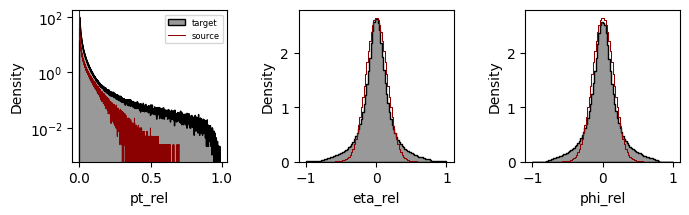

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2.25))
jets.target.histplot('pt_rel', ax=ax[0], stat='density', log_scale=(False,True), color='k', alpha=0.4, label='target')
jets.source.histplot('pt_rel', ax=ax[0], stat='density',  log_scale=(False,True), color='darkred', fill=False, lw=0.75, label='source')
jets.source.histplot('eta_rel', binrange=(-1,1), binwidth=0.02, ax=ax[1], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('eta_rel', binrange=(-1,1), binwidth=0.02,ax=ax[1], stat='density',  color='k', alpha=0.4, label='target')
jets.source.histplot('phi_rel', binrange=(-1,1), binwidth=0.02,ax=ax[2], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('phi_rel', binrange=(-1,1), binwidth=0.02, ax=ax[2], stat='density', color='k', alpha=0.4, label='target')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

(None, None)

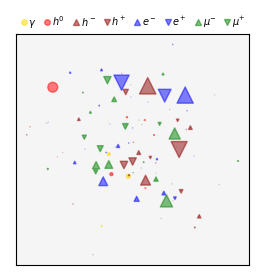

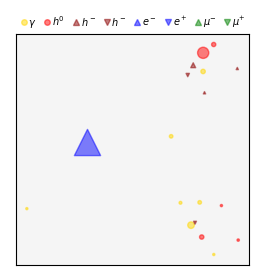

In [51]:
jets.source.display_cloud(idx=20,  scale_marker=200.0), jets.target.display_cloud(idx=20,  scale_marker=200.0)


In [65]:
jets.source.multiplicity.shape

torch.Size([100000])

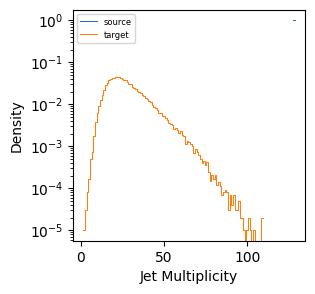

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(jets.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(jets.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

## Train CMB

In [3]:
from cmb.models.trainers import CMBTrainer
from cmb.models.architectures.epic import HybridEPiC
from cmb.dynamics.cmb import ConditionalMarkovBridge

hepic = HybridEPiC(config)
dynamics = ConditionalMarkovBridge(config)
model = CMBTrainer(config, dynamics, hepic, jets)
model.train()


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0


number of training parameters: 3063880
start training...


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
import torch
from cmb.models.pipelines import Pipeline
num_gen_jets = 3000

pipeline = Pipeline(config=config, trained_model=model, dynamics=dynamics)
test = JetsBoundaryData(config.data)

pipeline.generate_samples(source_continuous=test.source.continuous[:num_gen_jets], 
                          source_discrete=torch.tensor(test.source.discrete[:num_gen_jets]),
                          mask=test.source.mask[:num_gen_jets])


/tmp/ipykernel_2295265/962267515.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_discrete=torch.tensor(test.source.discrete[:num_gen_jets]),


In [11]:
gen_discrete = pipeline.jumps[-1].unsqueeze(-1)
gen_continuous = pipeline.paths[-1]  
gen_discrete = gen_discrete.squeeze(-1)

gen_discrete.shape, jets.target.discrete.shape

(torch.Size([3000, 128]), torch.Size([100000, 128]))

In [10]:
gen_discrete[0]

tensor([1., 2., 2., 0., 0., 0., 0., 0., 2., 1., 2., 0., 0., 0., 0., 1., 1., 0.,
        2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 2.,
        2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
        2., 0., 1., 1., 0., 0., 0., 2., 0., 2., 2., 1., 0., 1., 3., 0., 0., 0.,
        1., 0.])

In [12]:
gen_continuous[0]

tensor([[-1.1003e-02,  8.3910e-02, -3.8793e-01],
        [-1.5839e-03,  1.8515e-01, -2.3434e-02],
        [-7.7224e-02, -3.3932e-01, -3.6506e-01],
        [ 4.4312e-02,  1.7625e-01, -2.3450e-01],
        [-9.4066e-02,  2.6847e-01,  2.1852e-01],
        [ 5.1126e-02, -9.2755e-02, -2.1576e-01],
        [-1.3037e-01,  3.4793e-01,  1.0579e-01],
        [-7.3213e-02,  1.0454e-01, -8.8797e-04],
        [-1.0245e-01,  1.0752e-01, -1.5456e-01],
        [-7.6898e-02, -1.4351e-01, -1.8759e-01],
        [-7.4381e-02, -3.1555e-01, -6.7160e-02],
        [ 5.5271e-02, -8.7039e-01, -5.1298e-01],
        [-2.1631e-01, -6.9647e-01, -2.8676e-01],
        [-1.5344e-01, -4.7801e-02, -4.3713e-01],
        [-1.2525e-01, -3.4563e-01, -2.3238e-01],
        [-1.8503e-01, -3.7679e-01,  1.0273e-01],
        [-5.1332e-02, -2.2389e-01, -5.1086e-01],
        [-1.1036e-01, -1.9574e-01, -2.5852e-01],
        [-1.2807e-01, -2.5132e-01, -9.0721e-02],
        [-7.7600e-02, -3.6712e-01, -1.4106e-01],
        [-2.2110e-02

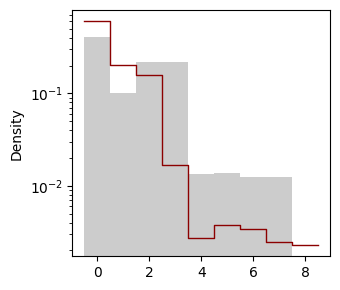

RuntimeError: "bincount_cpu" not implemented for 'Float'

In [6]:
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(3.5,3))

mask_gen = test.source.mask[:num_gen_jets] > 0
mask_data = jets.target.mask > 0

sns.histplot(jets.target.discrete[mask_data.squeeze(-1)], discrete=True, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True))
sns.histplot(gen_discrete[mask_gen.squeeze(-1)], discrete=True, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True))
plt.tight_layout()
plt.show()

torch.bincount(jets.target.discrete[mask_data.squeeze(-1)], minlength=8), torch.bincount(gen_discrete[mask_gen.squeeze(-1)], minlength=8)


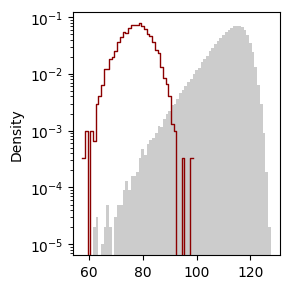

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def count_integer_in_rows(x, N):

    # Compare each element in the tensor with N and get a boolean tensor
    counts = (x == N).sum(dim=1)
    
    return counts


# Integer to count in each row
N = 0

# Get the counts of N in each row
gen_counts = (gen_discrete == N).sum(dim=1)
data_counts = (jets.target.discrete== N).sum(dim=1)

fig, ax = plt.subplots(1, 1, figsize=(3,3))
sns.histplot(data_counts , discrete=True, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True))
sns.histplot(gen_counts, discrete=True, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True))

plt.tight_layout()
plt.show()



In [93]:
gen_counts

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


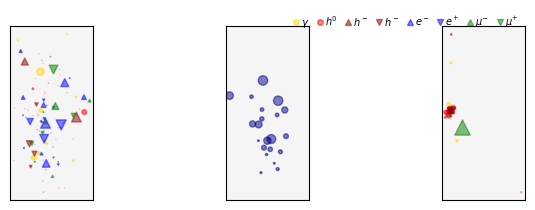

In [15]:
import torch
import matplotlib.pyplot as plt
from cmb.datasets.jetclass import ParticleClouds

generated = torch.cat([pipeline.paths[-1], test.source.mask[:num_gen_jets]], dim=-1)
jets_generated = ParticleClouds(generated) 

n=10
fig, ax = plt.subplots(1,3, figsize=(5.45, 2.2))
jets.source.display_cloud(idx=n, scale_marker=100, ax=ax[0])
jets_generated.display_cloud(idx=n, scale_marker=100, ax=ax[1])
jets.target.display_cloud(idx=n, scale_marker=100, ax=ax[2])
plt.tight_layout()
plt.savefig(model.workdir / 'particle_displays.png')
plt.show()

jumps = pipeline.jumps[-1].unsqueeze(-1) * test.source.mask[:num_gen_jets]

jumps[0]

varying number of constituents (max. 128)

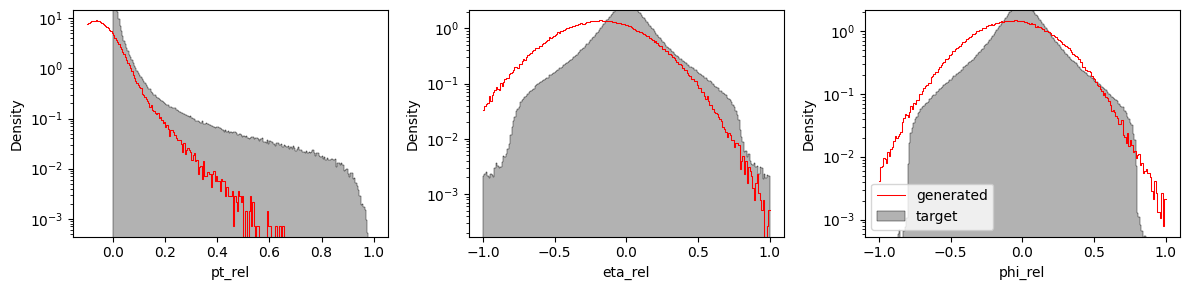

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(12,3))

jets_generated.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, ax=ax[0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[2], log_scale=(False, True), color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel',binrange=(-1, 1), binwidth=0.01, ax=ax[2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()

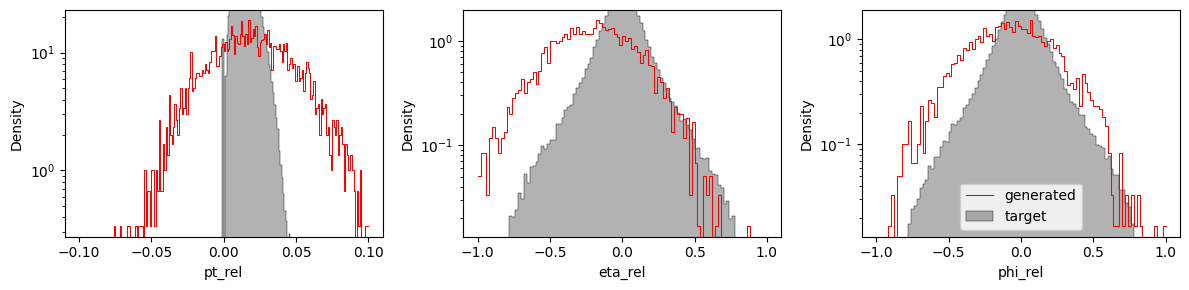

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

jets_generated.histplot('pt_rel', idx=10, binrange=(-.1, .1), binwidth=0.001, ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', idx=10, binrange=(-.1, .1), binwidth=0.001, ax=ax[0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', idx=10,  binrange=(-1, 1), binwidth=0.02, ax=ax[1],  log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[2],log_scale=(False, True),  color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()